In [1]:
from __future__ import print_function

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch
import math

import torch
import numpy as np
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

dtype = torch.float
device = torch.device("cpu")

In [12]:
from data_processing import *

In [105]:
data_2016, p_list_2016 = prepare_data(min_wind = 50, min_steps= 30, max_steps=60, one_hot = True, secondary = False)

Storm category is now added and one-hot.
Basin and Nature of the storm are now added and one-hot.
The dictionary of storms has been created.
The trajectories have now been padded.
There are 60 storms with 27 features, and maximum number of steps is 60 and minimum is 60.
The tensor has now been created.


In [102]:
p_list_2016

['LAT',
 'LON',
 'WMO_WIND',
 'WMO_PRES',
 'DIST2LAND',
 'STORM_SPEED',
 'storm_category_H1',
 'storm_category_H2',
 'storm_category_H3',
 'storm_category_H4',
 'storm_category_H5',
 'storm_category_TD',
 'storm_category_TS',
 'basin_EP',
 'basin_NI',
 'basin_SI',
 'basin_SP',
 'basin_WP',
 'nature_DS',
 'nature_ET',
 'nature_MX',
 'nature_NR',
 'nature_SS',
 'nature_TS']

In [66]:
data_1980, p_list_1980 = prepare_data(path = "ibtracs.since1980.list.v04r00.csv", min_wind = 50, min_steps = 45, max_steps=60, one_hot = False, secondary = True, dropna = True)

The dictionary of storms has been created.
The trajectories have now been padded.
There are 622 storms with 12 features, and maximum number of steps is 60 and minimum is 60.
The tensor has now been created.


In [72]:
#p_list_1980
data_1980.shape

torch.Size([621, 9, 60])

In [106]:
def no_dist2_land(data, p_list):
    test = data.clone()
    p2 = p_list.copy()
    p2.remove('DIST2LAND')
    data2 = torch.cat([test[:,:4,:], test[:,5:,:]], 1)
    return data2, p2

data_1980_nodist, p_list_1980_nodist = no_dist2_land(data_1980, p_list_1980)
data_2016_nodist, p_list_2016_nodist = no_dist2_land(data_2016, p_list_2016)

In [15]:
#2 dimensional SVD 
def mat_svd(X,r,m,n,t):
    #Mode-1 folding
    X1= X.reshape(m,n*t)
    U,S,V= torch.svd(X1,some=True, compute_uv=True) 
    U1=U[:,:r]
    #Mode-2 folding
    X2= X.reshape(m*t,n) 
    U,S,V= torch.svd(X2,some=True, compute_uv=True) 
    V1=V[:,:r]
    return U1,V1

#calculate MAE:
def get_mae(tensor1,tensor2):
    error = (tensor1-tensor2).abs().sum().item()
    return error 


#Slice Iteration: for one iteration 
def slice_iteration(tensor,r,m,n,t):
    new_tensor = torch.empty((m,n,t)) 
    #get U,V
    U,V = mat_svd(tensor, r,m,n,t)
    
    #update tensor 
    UU = torch.mm(U,torch.t(U))
    VV = torch.mm(V,torch.t(V))
    for i in range(t):
        new_tensor[:,:,i] = torch.mm(torch.mm(UU, tensor[:,:,i]),VV) 
    return new_tensor 

In [20]:
#Slice Learning 
def slice_learning(tensor_train,r,max_iteration=50,convergence=0.001, plot=False):
    m,n,t = tensor_train.shape
    new_tensor = torch.empty(m,n,t) 
    old_tensor = tensor_train 
    mae_all=[]
    
    mae = convergence + 1 
    #Iterative slice learning 
    for i in range(max_iteration): 
        if mae > convergence: 
            new_tensor = slice_iteration(old_tensor,r,m,n,t)
            mae = get_mae(new_tensor,old_tensor) 
            mae_all.append(mae)
            old_tensor = new_tensor 
    
    #plot MAE difference between iterations   
    max_i = len(mae_all)

    print('Code stopped at iteration = %s, and mae difference = %s'%(max_i,mae_all[-1]))
    if plot:
        plt.plot(np.linspace(1,max_i,max_i),mae_all)
        plt.yscale('log')
        plt.show()
    return new_tensor 

In [21]:
#Methods to standardize and de_standardize data along samples and timesteps (full standardization)
def standardize2(tensor): 
    new_tensor = tensor.clone()
    #calculate along 0 and 2nd (python index) dimension 
    std, mean = torch.std(tensor, dim=[0,2]), torch.mean(tensor, dim=[0,2])
    t = tensor.shape[1]
    for i in range(t):
        #element wise division
        new_tensor[:,i,:] = torch.div((tensor[:,i,:] - mean[i]), std[i])  
    #replace Nan with 0 
    new_tensor[new_tensor != new_tensor] = 0
    return new_tensor, mean, std

def de_standardize2(tensor, mean, std):
    t = tensor.shape[1]
    new_tensor = tensor.clone()
    for i in range(t):
        #element wise multiplication
        new_tensor[:,i,:] = torch.mul(tensor[:,i,:], std[i]) + mean[i] 
    return new_tensor 

In [39]:
#plot error bar chart
def plot_error(data, X_imputed, storm_id, p_list):#calculate error for all features for next 5 hour prediction: 
    error_5=[]
    error_10=[]
    error_15=[]
    for p in range(len(p_list)):
        #for each time
        error_v=np.abs(X_imputed[storm_id][p] - data[storm_id][p])
        error_5.append((error_v[time+5-1:time+5+1].sum()*(1/3)))#avg of time +5
        error_10.append((error_v[time+10-1:time+10+1].sum()*(1/3)))#avg of time +10
        error_15.append((error_v[time+15-1:time+15+1].sum()*(1/3)))#avg of time +15
    
    #plotting error:
    ind = np.arange(len(p_list)) 
    width = 0.3 
    plt.bar(ind,error_5,width, label='t+5')
    plt.bar(ind+width,error_10,width, label='t+10')
    plt.bar(ind+2*width,error_15,width, label='t+15')
    plt.xticks(ind + width / 2, p_list)
    plt.title('Avg error for t+5/10/15 StormID=%s' %( storm_id))
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.legend(loc='best')
    plt.show()
    return 

def plot_feature_prediction(data, X_imputed_0, X_imputed_1, X_imputed_2, storm_id, p_list, p_range, no_scale = False):
    for p in p_range:
        #plot predicted feature p with various normalization methods: 
        l = [i for i in range(data.shape[2])]
        if no_scale:
            plt.plot(l, np.array(X_imputed_0[storm_id][p]), label='imputed_no_scale')
        plt.plot(l, np.array(X_imputed_1[storm_id][p]),label='imputed_normalize')
        plt.plot(l, np.array(X_imputed_2[storm_id][p]), label='imputed_standardize')
        plt.plot(l, np.array(data[storm_id][p]),label='real')
        plt.axvline(x=time)
        plt.legend()
        plt.title('Feature= %s, StormID=%s' %(p_list[p],storm_id))
        plt.show()
    return 

In [81]:
def get_data_test(true_data, storm_id, time):
    test_data = true_data.clone()
    for t in range(time,true_data.shape[2]):
        test_data[storm_id,:,t] = test_data[storm_id,:,time-1]
    return test_data

In [90]:
#Testing function by deleting entries after time t for one particular storm  
def test(data, p_list, storm_id, time, r, p = 2, delete = True):
    data0 = data.clone()
    
    #data0= delete one storm data for testing  
    if delete:    
        data0 = get_data_test(data, storm_id, time)
    
    ### slice_learning 0: no_scale 
    X_imputed_0 = slice_learning(data0,r)
    
    ### slice learning 1: normalize data 
    data1 = F.normalize(data0, dim = 2)
    X_imputed_1 = slice_learning(data1,r)
    #de_normalize
    scale = torch.div(data[:,:,:time],X_imputed_1[:,:,:time])
    scale_mean = torch.mean(scale, dim=2)
    for i in range(X_imputed_1.shape[2]):
        X_imputed_1[:,:,i] = torch.mul(X_imputed_1[:,:,i], scale_mean) 
    
    ### slice_learning 2: standardize
    data2, mean, std = standardize2(data0)
    X_imputed_2 = slice_learning(data2, r)
    #de_standardize 
    X_imputed_2= de_standardize2(X_imputed_2, mean, std)
    
    return X_imputed_0, X_imputed_1, X_imputed_2

r = 8
Code stopped at iteration = 50, and mae difference = 257218.046875
Code stopped at iteration = 50, and mae difference = 0.002939649624750018
Code stopped at iteration = 50, and mae difference = 0.01616809330880642


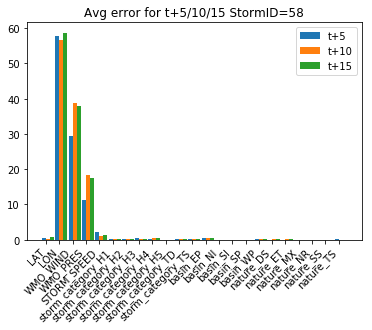

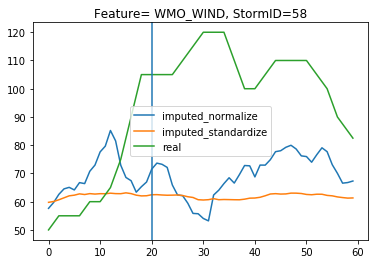

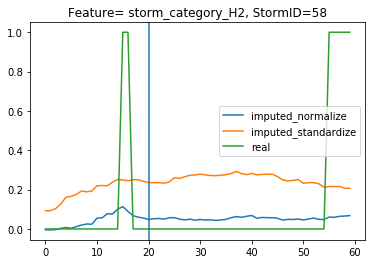

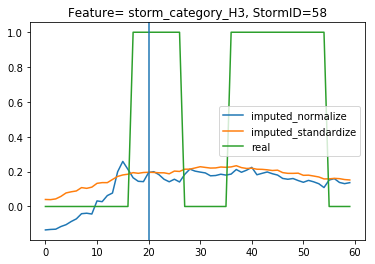

r = 13
Code stopped at iteration = 50, and mae difference = 53.2903938293457
Code stopped at iteration = 50, and mae difference = 0.014365633018314838
Code stopped at iteration = 50, and mae difference = 0.054566893726587296


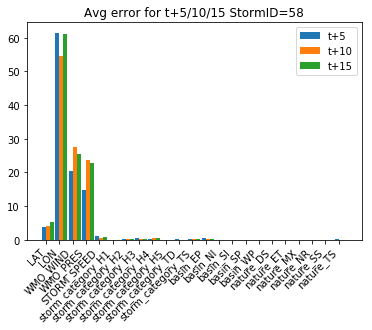

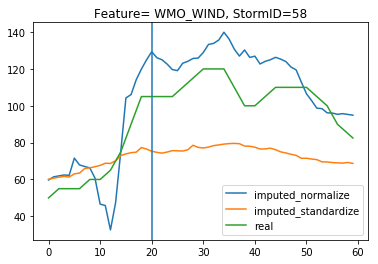

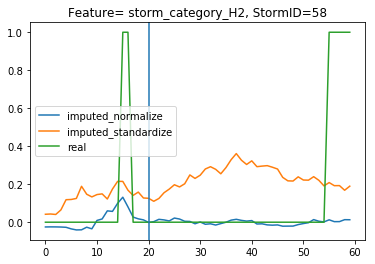

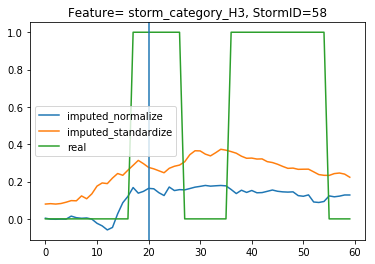

r = 20
Code stopped at iteration = 50, and mae difference = 413.842529296875
Code stopped at iteration = 50, and mae difference = 0.005112058483064175
Code stopped at iteration = 50, and mae difference = 0.13175612688064575


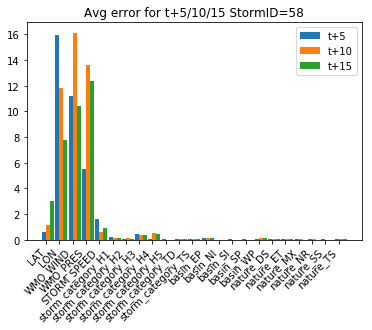

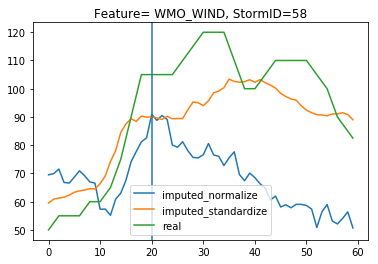

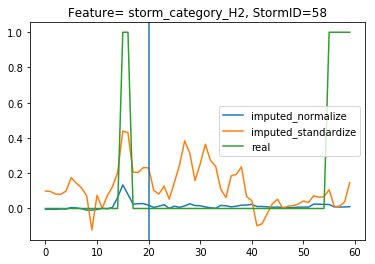

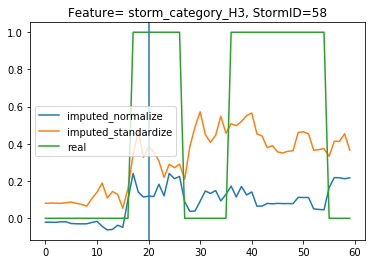

In [110]:
#60 is big storm not easy to predict
storm_id = 58
time = 20
data = data_2016_nodist
p_list = p_list_2016_nodist
for r in [8,13, 20]:
    print ('r =', r)
    #test learning for a particular storm_id 
    X_imputed_0, X_imputed_1, X_imputed_2 = test(data, p_list, storm_id, time, r, delete = True)
    #make some plots:
    plot_error(data, X_imputed_2, storm_id, p_list)
    plot_feature_prediction(data, X_imputed_0, X_imputed_1, X_imputed_2, storm_id, p_list, p_range=[2, 6, 7])

Code stopped at iteration = 50, and mae difference = 54.31429672241211
Code stopped at iteration = 50, and mae difference = 33.93944549560547
Code stopped at iteration = 50, and mae difference = 37.03579330444336
Code stopped at iteration = 50, and mae difference = 35.57888412475586
Code stopped at iteration = 50, and mae difference = 46.03409957885742


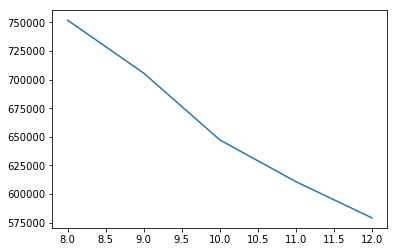

[751936.5, 705677.375, 647327.5625, 610805.5625, 579140.875]

In [99]:
#get best r

def get_best_r(data, r_min, r_max):
    r_list = []
    for r in range(r_min, r_max):
        X_imputed = slice_learning(data,r, plot = False)
        r_list.append(get_mae(X_imputed,data))
    plt.plot([r for r in range(r_min, r_max)], r_list)
    plt.show()
    return r_list

get_best_r(data_1980_nodist, 8, 13)